In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
from mpmath import polylog
from sklearn.model_selection import train_test_split
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import math
import random
from sklearn.model_selection import train_test_split
import time
import itertools
from sklearn.preprocessing import MinMaxScaler


class MLP(nn.Module):
    """
        Class defining neural network approximator for the integrand.
    """

    def __init__(self, input_size, hidden_size):
        """
            Main constructor.

            :param input_size: input layer size (number of integrand dimensions)
            :param hidden_size: hidden layer size (arbitrary value, which would be chosen when training the network)
        """
        super(MLP, self).__init__()
        self.input_size = input_size
        self.input_hidden_layer = nn.Linear(input_size, hidden_size)  # initialisation of input->hidden layers structure
        self.sigmoid_activation = nn.Sigmoid()  # hidden layer activation function
        self.output_layer = nn.Linear(hidden_size, 1)  # output layer initialisation (always size 1)

    def forward(self, x):
        """
            Forward propagation of the data through the network.

            :param x:    the data to be propagated

            :returns: data after the forward propagation
        """
        x = self.input_hidden_layer(x)  # input->hidden propagation
        x = self.sigmoid_activation(x)  # sigmoid activation function applied
        x = self.output_layer(x)  # hidden->output propagation

        return x


def train(model, criterion, optimizer, x_train, y_train, epochs, verbose=True):
    """
        Trains the model.

        :param model:      The model to be trained
        :param criterion:  Loss function
        :param optimizer:  Optimization algorithm
        :param x_train:    Training inputs
        :param y_train:    True labels
        :param epochs:     Number of training epochs
        :param verbose:    Boolean depicting whether should the network print each 100 epochs done message,
                           or only the completion message.

        :returns: loss functions history
    """
    loss_history = []
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train)  # forward propagation of all the data
        loss = criterion(predictions, y_train)  # loss function calculation

        optimizer.zero_grad()  # gradients are being reset
        loss.backward()  # backwards data propagation
        optimizer.step()  # optimization step (network params are being updated)

        loss_history.append(loss.item())  # current loss function added to history

        # hereon the logs are being printed
        if verbose:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}')
    total_time = time.time() - start_time
    print(f'Training done! Time elapsed: {total_time:.2f} seconds')

    return loss_history  # loss history is returned


def test(model, criterion, x_test, y_test):
    """
        Tests the model.

        :param model:     The trained model
        :param criterion: Loss function
        :param x_test:    Test inputs
        :param y_test:    True labels

        :returns: test loss function value
    """
    with torch.no_grad():  # no gradients will be calculated
        predictions = model(x_test)  # forward data propagation
        loss = criterion(predictions, y_test)  # loss function for the test data

    return loss.item()  # loss function value (item() required to convert tensor to scalar)


def predict_with(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.

        :param model:  the trained model
        :param x_test: test inputs

        :returns: predicted function value
    """
    with torch.no_grad():
        prediction = model(x_test)  # forward data propagation

    return prediction


def extract_params(model):
    """
        Extracts weights and biases from the network.

        :param model: the trained model

        :returns: tuple of 4 numpy.ndarray-s with biases1, weights1, biases2 and weights2
                  (number represents 1 - input->hidden layers params, 2 - hidden->output layers params)
    """

    b1 = model.input_hidden_layer.bias.detach().numpy()
    w1 = model.input_hidden_layer.weight.detach().numpy()
    b2 = model.output_layer.bias.detach().numpy()
    w2 = model.output_layer.weight.detach().numpy().flatten()

    return b1, w1, b2, w2


class NeuralNumericalIntegration:

    @staticmethod
    def calculate(alphas, betas, network_params, n_dims=1):
        """
            Calculates integrand value using neural network model params
            across given boundaries.

            :param alphas:         lower boundaries sequence (should be placed in integration order)
            :param betas:          upper boundaries sequence (should be placed in integration order)
            :param network_params: params for the trained neural network
            :param n_dims:          number of integrand dimensions (default value is 1)

            :returns: integrand value
        """

        b1, w1, b2, w2 = network_params

        def Phi_j(b1_j_, w1_j_):
            def xi(r_):
                prod_ = 1
                for d in range(1, n_dims + 1):
                    prod_ *= (-1) ** (r_ / (2 ** (n_dims - d)))

                return prod_

            def l(i_, r_):
                if r_ / (2 ** (n_dims - i_ + 1)) % 2 == 0:
                    return alphas[i_]
                else:
                    return betas[i_]

            Phi_sum = 0

            for r in range(1, 2 ** n_dims + 1):
                sum_ = 0
                for i in range(n_dims):
                    sum_ += w1_j_[i] * l(i, r)
                Phi_sum += xi(r) * polylog(n_dims, -np.exp(-b1_j_ - sum_))

            return Phi_sum

        integral_sum = 0

        prod_bound = 1
        for i in range(n_dims):
            prod_bound *= betas[i] - alphas[i]

        for w2_j, w1_j, b1_j in zip(w2, w1, b1):

            Phi_j_ = Phi_j(b1_j, w1_j)
            prod_w = 1
            for i in range(n_dims):
                prod_w *= w1_j[i]

            integral_sum += w2_j * (prod_bound + Phi_j_ / prod_w)

        return float((b2 * prod_bound + integral_sum)[0])

    @staticmethod
    def integrate(model, alphas, betas, n_dims=1):
        """
            Integrates function-approximator (model) of n-dim dimensions over given boundaries.

            :model: the trained model-approximator
            :param alphas: lower boundaries sequence (should be placed in integration order)
            :param betas:  upper boundaries sequence (should be placed in integration order)
            :param n_dims: number of integrand dimensions (default value is 1)

            :returns: neural numeric integration result
        """
        network_params = MLP.extract_params(model)

        return NeuralNumericalIntegration.calculate(alphas, betas, network_params, n_dims)

# Hyperparams

In [2]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = 0.0
b = 1.0

# Oscillatory 1D: Example

In [3]:
def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

def osc_1d_float(X):
    return math.cos(2 * math.pi * u + X * c)

In [4]:
u = random.uniform(0, 1)
cs = random.uniform(0, 1)
c = cs

In [5]:
X, y = generate_data(osc_1d, params=[u,c], lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

NameError: name 'generate_data' is not defined

In [6]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Oscillatory 1D')
plt.grid(True)
plt.show()

NameError: name 'X' is not defined

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [129]:
input_size = 1
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [130]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/5000], Loss: 0.0757163912
Epoch [200/5000], Loss: 0.0647155568
Epoch [300/5000], Loss: 0.0545887016
Epoch [400/5000], Loss: 0.0447357930
Epoch [500/5000], Loss: 0.0350361243
Epoch [600/5000], Loss: 0.0257063266
Epoch [700/5000], Loss: 0.0172666162
Epoch [800/5000], Loss: 0.0103747491
Epoch [900/5000], Loss: 0.0054799453
Epoch [1000/5000], Loss: 0.0025359904
Epoch [1100/5000], Loss: 0.0010556624
Epoch [1200/5000], Loss: 0.0004324869
Epoch [1300/5000], Loss: 0.0002096105
Epoch [1400/5000], Loss: 0.0001396118
Epoch [1500/5000], Loss: 0.0001185566
Epoch [1600/5000], Loss: 0.0001108712
Epoch [1700/5000], Loss: 0.0001063045
Epoch [1800/5000], Loss: 0.0001023240
Epoch [1900/5000], Loss: 0.0000983939
Epoch [2000/5000], Loss: 0.0000944251
Epoch [2100/5000], Loss: 0.0000904143
Epoch [2200/5000], Loss: 0.0000863728
Epoch [2300/5000], Loss: 0.0000823140
Epoch [2400/5000], Loss: 0.0000782517
Epoch [2500/5000], Loss: 0.0000741994
Epoch [2600/5000], Loss: 0.0000701707
Epoch [2700/5000], Lo

In [131]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


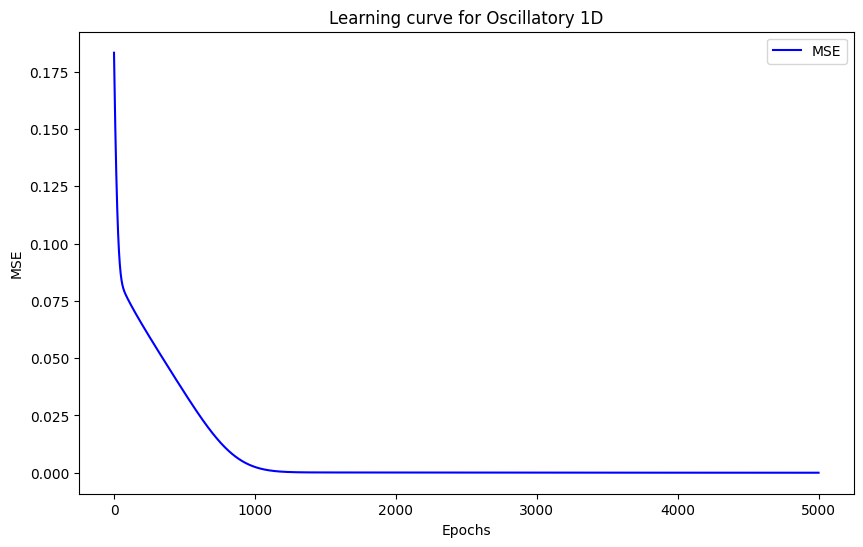

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [133]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000058017


In [134]:
bs1, we1, bs2, we2 = extract_model_params(model)

In [135]:
a = 0.0
b = 1.0

In [140]:
nni = get_NN_integral(a, b, bs1, we1, bs2, we2)

nni

0.061260837151441906

In [141]:
result, error = scipy.integrate.quad(osc_1d_float, a, b)

print("Integral:", result)
print("Error:", error)

Integral: 0.8532598358708471
Error: 9.473087157716965e-15


In [142]:
abs(nni - result)

0.7919989987194052